# Requirements

In [ ]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


# Libraries

In [ ]:
# Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# System Libraries
import os
import random
import os.path
from pathlib import Path

# Visualization Libraries
import cv2
import seaborn as sns
import matplotlib.cm as cm
from PIL import Image, ImageChops, ImageEnhance

# Metrics
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2, Xception

# Extra
from termcolor import colored
#from google.colab import drive
import zipfile

# Data

## Global Variable

In [ ]:
PATH = '/kaggle/input/deepfakesss/similar'
PATH_poisoning = '/kaggle/input/adversarial/adversarial'
PATH_styletransfer = '/kaggle/input/deepfakesss/similar/style_transfer'
PATH_inpainting = '/kaggle/input/deepfakesss/similar/inpainting'
PATH_cutmix = "/kaggle/input/deepfakesss/similar/cutmix/"
PATH_old = '/kaggle/input/dataset'
images = []
class_list = []
labels_class = ['Original', 'AI Generated']
labels_class

['Original', 'AI Generated']

### Load Adversarial

In [ ]:
# class_0_count = 0
# class_1_count = 0
# max_original_images = 500  # Max original images to ensure a 1:3 ratio
# max_ai_generated_images = max_original_images * 3  # Corresponding max AI-generated imagesc

# # Get the list of folders and shuffle
# folders = os.listdir(PATH_poisoning)
# random.shuffle(folders)

# for i, class_name in enumerate(folders):
#     # Get the list of files in the current folder and shuffle
#     files = os.listdir(os.path.join(PATH_poisoning, class_name))
#     random.shuffle(files)

#     for j, file in enumerate(files):
#         if class_0_count >= max_original_images and class_1_count >= max_ai_generated_images:
#             break  # Stop if both classes have reached the limit

#         if file in ['original.png', 'adv_FGSM.png', 'adv_APGD.png', 'adv_PGD.png']:
#             image = load_img(os.path.join(PATH_poisoning, class_name, file))
#             image = img_to_array(image) / 255.0

#             # Resize image
#             image = tf.image.resize(image, (224, 224))
#             images.append(image)

#             # Check class and append labels
#             if file == 'original.png' and class_0_count < max_original_images:
#                 class_list.append(0)
#                 class_0_count += 1
#             elif file != 'original.png' and class_1_count < max_ai_generated_images:
#                 class_list.append(1)
#                 class_1_count += 1

#     # Break the outer loop if both classes have reached the limit
#     if class_0_count >= max_original_images and class_1_count >= max_ai_generated_images:
#         break

# print(f"Total images processed: {len(images)}")
# print(f"Classes distribution: {class_list.count(0)} originals, {class_list.count(1)} generated")

### Load Inpainting Image

In [ ]:
class_0_count = 0
class_1_count = 0
max_images_per_class = 750

# Get the list of folders and shuffle them
folders = os.listdir(PATH_inpainting)
random.shuffle(folders)

for i, class_name in enumerate(folders):
    # Get the list of files in the current folder and shuffle them
    files = os.listdir(os.path.join(PATH_inpainting, class_name))
    random.shuffle(files)

    for j, file in enumerate(files):
        if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
            break  # Stop if both classes have reached the limit

        if file in ['original.png', 'inpainting.png']:
            image = load_img(os.path.join(PATH_inpainting, class_name, file))
            image = img_to_array(image) / 255.0

            # Resize image
            image = tf.image.resize(image, (224, 224))
            images.append(image)

            # Append the class labels
            if file == 'original.png' and class_0_count < max_images_per_class:
                class_list.append(0)
                class_0_count += 1
            elif file == 'inpainting.png' and class_1_count < max_images_per_class:
                class_list.append(1)
                class_1_count += 1

    # Break the outer loop if both classes have reached the limit
    if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
        break

print(f"Total images processed: {len(images)}")
print(f"Classes distribution: {class_list.count(0)} originals, {class_list.count(1)} generated")

Total images processed: 1500
Classes distribution: 750 originals, 750 generated


### Load Style Transfer Image

In [ ]:
max_images_per_class_per_folder = 20

# Get a list of folders and shuffle them
folders = os.listdir(PATH_styletransfer)
random.shuffle(folders)

# Iterate through each shuffled folder
for class_name in folders:
    class_path = os.path.join(PATH_styletransfer, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip if not a folder

    # Get a list of files in the current folder and shuffle them
    files = os.listdir(class_path)
    random.shuffle(files)

    # Initialize lists to hold selected files for "human" and "AI"
    human_files = []
    ai_files = []

    for file in files:
        file_path = os.path.join(class_path, file)

        # Collect "human" files
        if file.endswith("original.png") and len(human_files) < max_images_per_class_per_folder:
            human_files.append(file_path)

        # Collect "AI" files
        elif file.endswith("generated.png") and len(ai_files) < max_images_per_class_per_folder:
            ai_files.append(file_path)

        # Stop collecting if both lists are filled
        if len(human_files) == max_images_per_class_per_folder and len(ai_files) == max_images_per_class_per_folder:
            break

    # Process the collected files
    for human_file in human_files:
        image = load_img(human_file)
        image = img_to_array(image) / 255.0
        image = tf.image.resize(image, (224, 224))  # Resize image
        images.append(image)
        class_list.append(0)  # Class 0 for "human"

    for ai_file in ai_files:
        image = load_img(ai_file)
        image = img_to_array(image) / 255.0
        image = tf.image.resize(image, (224, 224))  # Resize image
        images.append(image)
        class_list.append(1)  # Class 1 for "AI"

print(f"Total images processed: {len(images)}")
print(f"Classes distribution: {class_list.count(0)} originals, {class_list.count(1)} generated")


Total images processed: 2580
Classes distribution: 1290 originals, 1290 generated


### Load Cutmix

In [ ]:
# source_image_count = 0
# cutmix_image_count = 0
# max_images_per_class = 500  # Limit per class

# # Get a list of files and shuffle them
# files = os.listdir(PATH_cutmix)
# random.shuffle(files)

# # Iterate through each file
# for file in files:
#     if source_image_count >= max_images_per_class and cutmix_image_count >= max_images_per_class:
#         break  # Stop if limits are reached

#     file_path = os.path.join(PATH_cutmix, file)

#     # Process CutMix "generated" images
#     if file.endswith("generated.png") and cutmix_image_count < max_images_per_class:
#         image = load_img(file_path)
#         image = img_to_array(image) / 255.0
#         image = tf.image.resize(image, (224, 224))  # Resize image
#         images.append(image)
#         class_list.append(1)  # 1: CutMix image
#         cutmix_image_count += 1

#     # Process "source" images (source_1 and source_2)
#     elif file.endswith("source_1.png") or file.endswith("source_2.png"):
#         if source_image_count < max_images_per_class:
#             image = load_img(file_path)
#             image = img_to_array(image) / 255.0
#             image = tf.image.resize(image, (224, 224))  # Resize image
#             images.append(image)
#             class_list.append(0)  # 0: Source image
#             source_image_count += 1

# # Print statistics
# print(f"Total images processed: {len(images)}")
# print(f"Classes distribution: {class_list.count(0)} originals, {class_list.count(1)} generated")

### Load Old Dataset

In [ ]:
allowed_classes = [
    'AI_SD_art_nouveau', 'AI_SD_baroque', 'AI_SD_expressionism', 'AI_SD_impressionism',
    'AI_SD_realism', 'AI_SD_renaissance', 'AI_SD_romanticism',
    'AI_SD_surrealism', 'AI_SD_ukiyo-e',
    'art_nouveau', 'surrealism', 'baroque', 'ukiyo_e', 'expressionism', 'impressionism',
    'realism', 'renaissance', 'romanticism'
]

max_images_per_class = 60
class_0_count = 0
class_1_count = 0

# Process folders and images
for class_name in allowed_classes:
    class_path = os.path.join(PATH_old, class_name)

    if os.path.exists(class_path):
        # Get all files in the directory and limit to the first 100
        file_names = os.listdir(class_path)[:max_images_per_class]

        for file_name in file_names:
            file_path = os.path.join(class_path, file_name)

            # Load the image
            image = load_img(file_path)
            image = img_to_array(image) / 255.0

            # Resize the image
            image = tf.image.resize(image, (224, 224))
            images.append(image)

            # Assign label: 1 for AI, 0 for Original
            label = 1 if "AI_" in class_name else 0
            class_list.append(label)

# Print statistics
print(f"Total images processed: {len(images)}")
print(f"Classes distribution: {class_list.count(0)} originals, {class_list.count(1)} generated")

Total images processed: 3660
Classes distribution: 1830 originals, 1830 generated


## Data Distribution

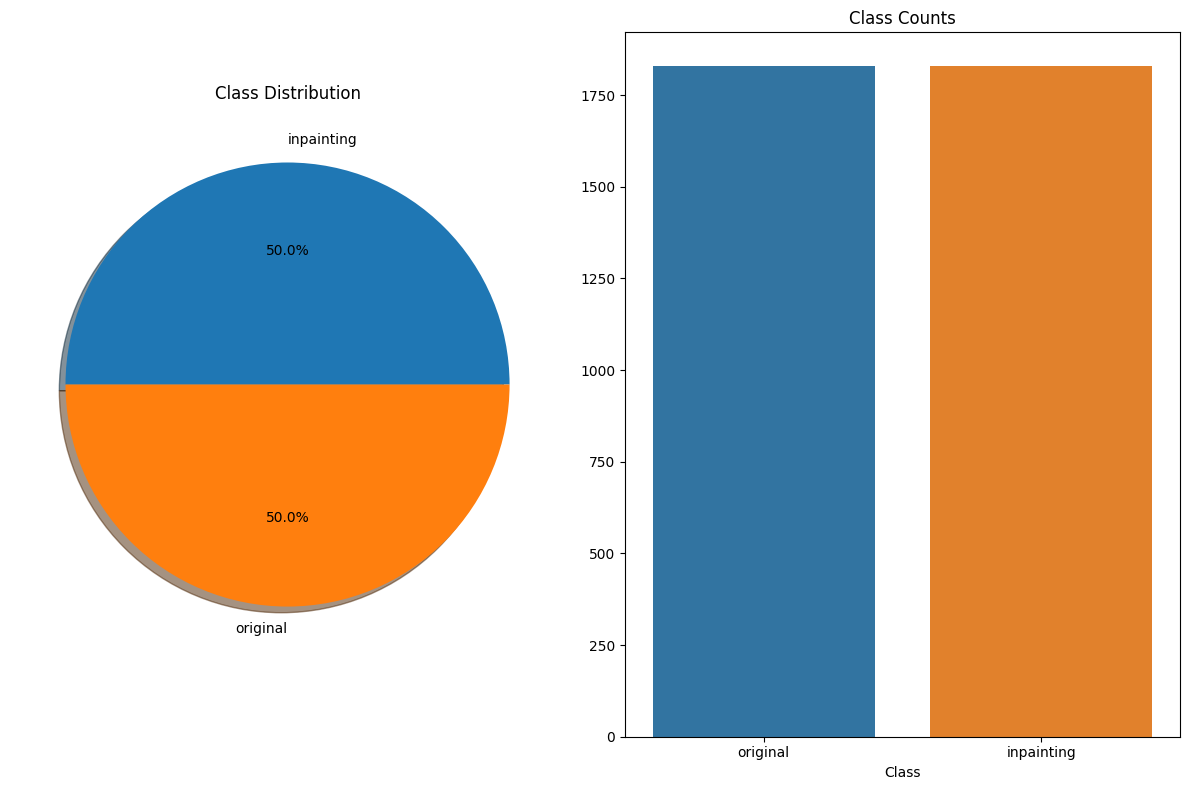

In [ ]:
from collections import Counter

class_labels = {0: 'original', 1: 'inpainting'}
mapped_class_list = [class_labels[c] for c in class_list]
class_counts = Counter(mapped_class_list)
class_series = pd.Series(class_counts)


fig, ax = plt.subplots(1, 2, figsize=(12, 8))
class_series.plot(kind='pie', ax=ax[0], autopct='%1.1f%%', shadow=True)
ax[0].set_title('Class Distribution')
ax[0].set_ylabel('')
sns.countplot(x=mapped_class_list, ax=ax[1], order=['original', 'inpainting'])
ax[1].set_title('Class Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

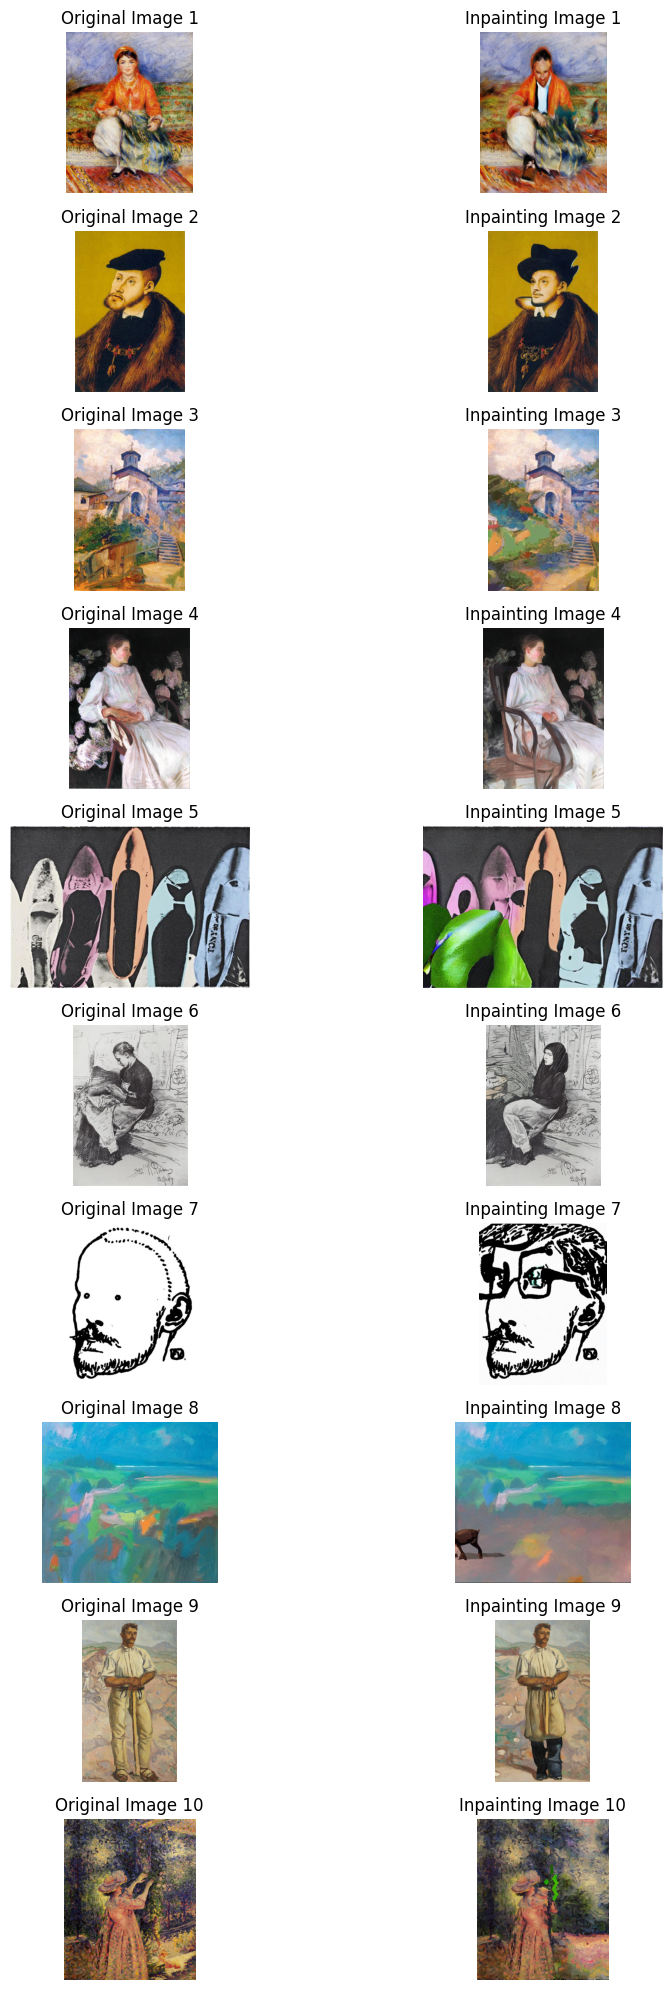

In [ ]:
num_images = 10

# Get all subfolders inside the base directory
subfolders = [os.path.join(PATH_inpainting, folder) for folder in os.listdir(PATH_inpainting) if os.path.isdir(os.path.join(PATH_inpainting, folder))]

# Randomize the folder order
random.shuffle(subfolders)

# Initialize plot
fig, axs = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

# Plot images
for i, folder in enumerate(subfolders[:num_images]):
    original_path = os.path.join(folder, "original.png")
    inpainting_path = os.path.join(folder, "inpainting.png")

    # Load images
    if os.path.exists(original_path) and os.path.exists(inpainting_path):
        original_img = Image.open(original_path)
        inpainting_img = Image.open(inpainting_path)

        # Plot original image
        axs[i, 0].imshow(original_img)
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Original Image {i+1}")

        # Plot inpainting image
        axs[i, 1].imshow(inpainting_img)
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f"Inpainting Image {i+1}")
    else:
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 0].set_title(f"Missing Images in Folder {os.path.basename(folder)}")

# Set overall title and layout adjustments
plt.tight_layout()
plt.show()


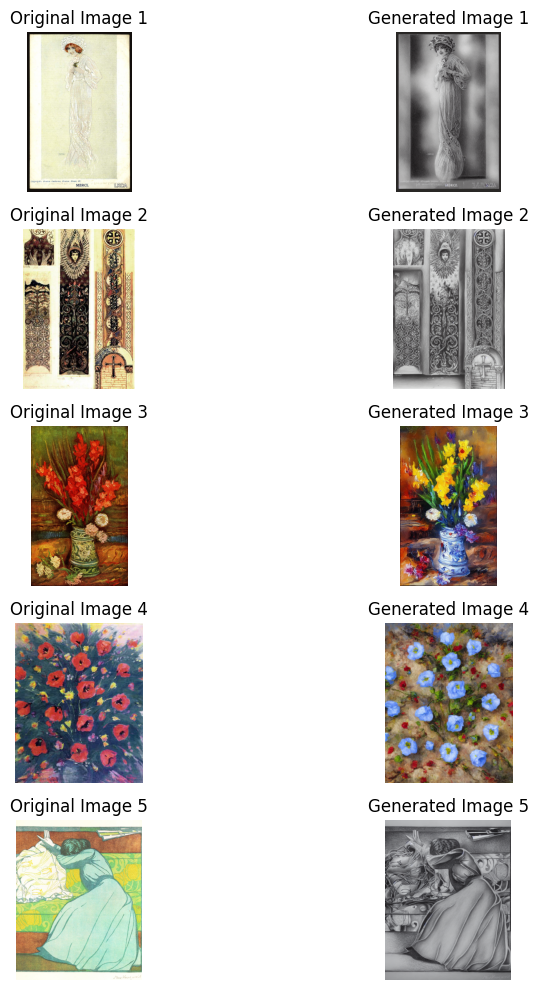

In [ ]:
import os
import random
from matplotlib import pyplot as plt
from PIL import Image


# Number of images to display per category
num_images = 5

# Dictionary to store paired image paths by number
paired_images = {}

# Collect and pair images based on the shared number in filenames
for folder in os.listdir(PATH_styletransfer):
    folder_path = os.path.join(PATH_styletransfer, folder)
    if os.path.isdir(folder_path):  # Only process directories
        for file_name in os.listdir(folder_path):
            if file_name.endswith("_generated.png"):
                num = file_name.split("_")[0]  # Extract the number
                if num not in paired_images:
                    paired_images[num] = {}
                paired_images[num]['generated'] = os.path.join(folder_path, file_name)
            elif file_name.endswith("_original.png"):
                num = file_name.split("_")[0]  # Extract the number
                if num not in paired_images:
                    paired_images[num] = {}
                paired_images[num]['original'] = os.path.join(folder_path, file_name)

# Filter pairs that have both `generated` and `original`
valid_pairs = [pair for pair in paired_images.values() if 'generated' in pair and 'original' in pair]

# Shuffle the pairs
random.shuffle(valid_pairs)

# Select the first `num_images` pairs
selected_pairs = valid_pairs[:num_images]

# Initialize plot
fig, axs = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

# Plot images
for i, pair in enumerate(selected_pairs):
    # Load generated image
    generated_img = Image.open(pair['generated'])
    axs[i, 1].imshow(generated_img)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Generated Image {i+1}")

    # Load original image
    original_img = Image.open(pair['original'])
    axs[i, 0].imshow(original_img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original Image {i+1}")

# Set overall title and layout adjustments
plt.tight_layout()
plt.show()


## Augmentation

### Function

In [ ]:
def augment_image(image):
    # Convert to tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Apply random transformations
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)    # Random vertical flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    image = tf.image.random_crop(tf.image.resize_with_crop_or_pad(image, 240, 240), (224, 224, 3))  # Random crop to target size

    return image

## Random Image to Plot

In [ ]:
def augment_flip_horizontal(image):
    return tf.image.flip_left_right(image)

def augment_flip_vertical(image):
    return tf.image.flip_up_down(image)

def augment_brightness(image, delta=0.2):
    return tf.image.adjust_brightness(image, delta)

def augment_contrast(image, lower=0.8, upper=1.2):
    return tf.image.random_contrast(image, lower=lower, upper=upper)

### Original Image

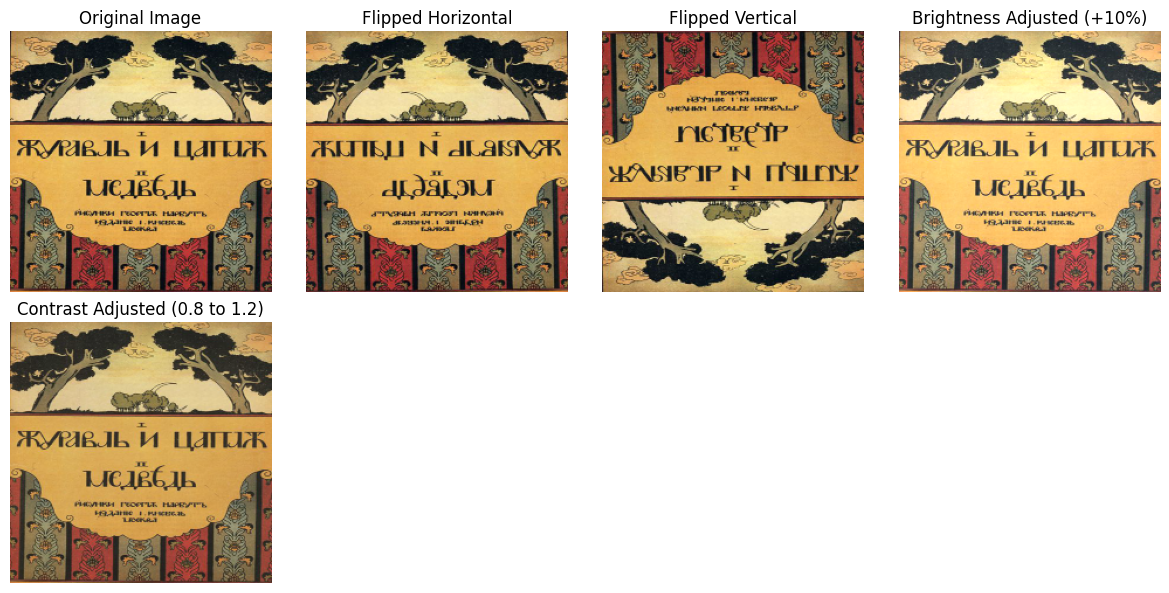

In [ ]:
while True:
    class_name = random.choice(os.listdir(PATH_inpainting))
    file = random.choice(os.listdir(os.path.join(PATH_inpainting, class_name)))
    if file == "original.png":
        image_path = os.path.join(PATH_inpainting, class_name, file)
        break  # Exit the loop when "original.png" is found

image = load_img(image_path)
image = img_to_array(image)
image = image/255.0
image = tf.image.resize(image, (224, 224))

augmented_images = [
    augment_flip_horizontal(image),
    augment_flip_vertical(image),
    augment_brightness(image, delta=0.1),  # Mengurangi kecerahan sebesar 10%
    augment_contrast(image, lower=0.8, upper=1.2),  # Kontras pada rentang yang ditentukan
]

titles = [
    "Flipped Horizontal",
    "Flipped Vertical",
    "Brightness Adjusted (+10%)",
    "Contrast Adjusted (0.8 to 1.2)"
]

plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (aug_img, title) in enumerate(zip(augmented_images, titles), start=2):
    plt.subplot(2, 4, i)
    plt.imshow(tf.squeeze(aug_img), cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

### AI - Generated Image

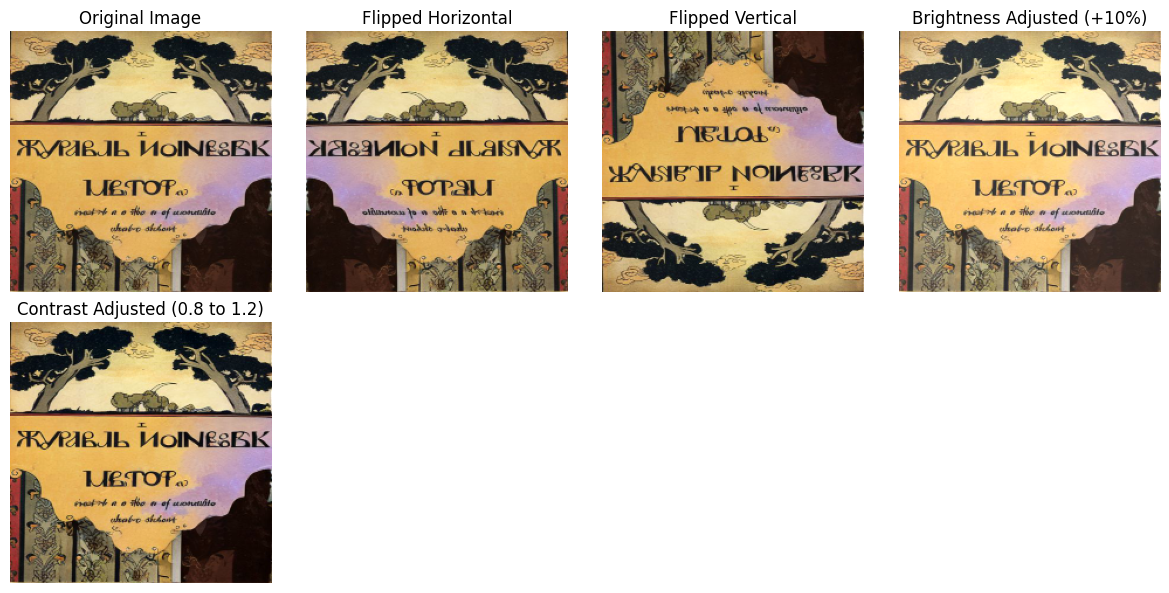

In [ ]:
image_path = os.path.join(PATH_inpainting, class_name, 'inpainting.png')

image = load_img(image_path)
image = img_to_array(image)
image = image/255.0
image = tf.image.resize(image, (224, 224))

augmented_images = [
    augment_flip_horizontal(image),
    augment_flip_vertical(image),
    augment_brightness(image, delta=0.1),  # Mengurangi kecerahan sebesar 10%
    augment_contrast(image, lower=0.8, upper=1.2),  # Kontras pada rentang yang ditentukan
]

titles = [
    "Flipped Horizontal",
    "Flipped Vertical",
    "Brightness Adjusted (+10%)",
    "Contrast Adjusted (0.8 to 1.2)"
]

plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (aug_img, title) in enumerate(zip(augmented_images, titles), start=2):
    plt.subplot(2, 4, i)
    plt.imshow(tf.squeeze(aug_img), cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Encoding Data & Image as array

In [ ]:
y = np.array(class_list)
images = np.asarray(images)

# Data Processing

## Splitting Data

In [ ]:
total_samples = len(images)

X_train, X_temp, y_train, y_temp = train_test_split(images, y, test_size=0.2, random_state=0, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

# Size
print(f"Train set size: {len(X_train)} ({len(X_train) / total_samples:.2%})")
print(f"Validation set size: {len(X_val)} ({len(X_val) / total_samples:.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test) / total_samples:.2%})")

Train set size: 2928 (80.00%)
Validation set size: 366 (10.00%)
Test set size: 366 (10.00%)


## Augmenting Training Dataset

In [ ]:
augmented_images = []
augmented_labels = []

for image, label in zip(X_train, y_train):
    augmented_image = augment_image(image)
    augmented_images.append(augmented_image)

    augmented_labels.append(label)


# Convert augmented lists to numpy arrays
X_train = np.array(augmented_images)
y_train = np.array(augmented_labels)

# Model

## Model Architecture

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Global Average Pooling layer

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Callbacks

In [ ]:
# Model Checkpoint
checkpoint_cb = ModelCheckpoint('MyModel.weights.h5', save_best_only=True, save_weights_only=True, save_freq='epoch')

# Early Stopping
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## Compile

In [ ]:
model.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

# Training

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs = 50,
    validation_data = (X_val, y_val),
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr],
    batch_size = 32
)

Epoch 1/50


I0000 00:00:1734515272.320809     114 service.cc:145] XLA service 0x7ea338015df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734515272.320867     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734515297.095763     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6447 - loss: 0.6448

I0000 00:00:1734515338.245899     114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_2', 4 bytes spill stores, 4 bytes spill loads



92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 531ms/step - accuracy: 0.6454 - loss: 0.6442 - val_accuracy: 0.5656 - val_loss: 37.7334 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - accuracy: 0.7914 - loss: 0.4702 - val_accuracy: 0.6694 - val_loss: 1.6432 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - accuracy: 0.8636 - loss: 0.3395 - val_accuracy: 0.8224 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.8950 - loss: 0.2730 - val_accuracy: 0.7213 - val_loss: 0.8042 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.9227 - loss: 0.2105 - val_accuracy: 0.7186 - val_loss: 1.5333 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.9328 - loss: 0.1829 - val_accuracy: 0.6120 - val_loss: 1.9508 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.9461 - loss: 0.1344 - val

In [ ]:
model.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7895 - loss: 0.5933


[0.5920483469963074, 0.8087431788444519]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities using the model
predictions = model.predict(X_test)

# Convert probabilities to class labels using a threshold of 0.5
predicted_labels = (predictions > 0.5).astype(int)

# If y_test is one-hot encoded, convert it to class indices
if len(y_test.shape) > 1:  # Check if y_test is one-hot encoded
    true_labels = np.argmax(y_test, axis=1)
else:
    true_labels = y_test

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])

print(report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step
              precision    recall  f1-score   support

     Class 0       0.81      0.81      0.81       187
     Class 1       0.80      0.80      0.80       179

    accuracy                           0.81       366
   macro avg       0.81      0.81      0.81       366
weighted avg       0.81      0.81      0.81       366



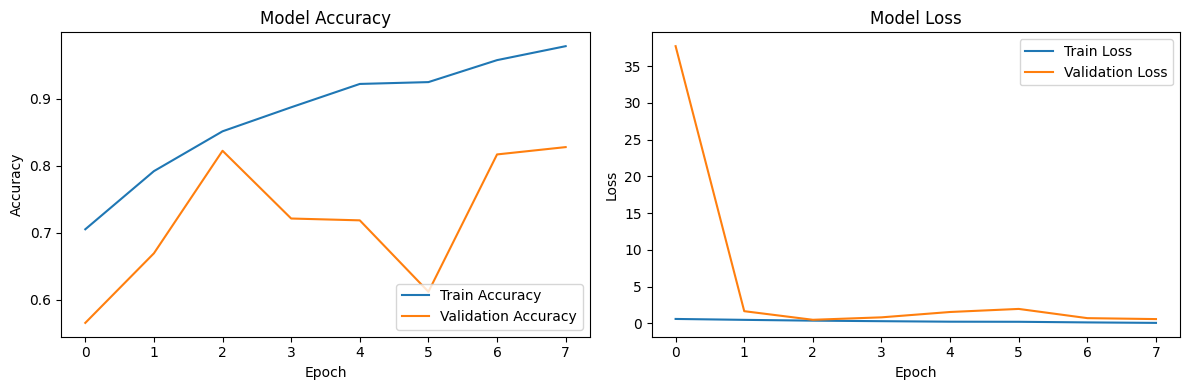

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


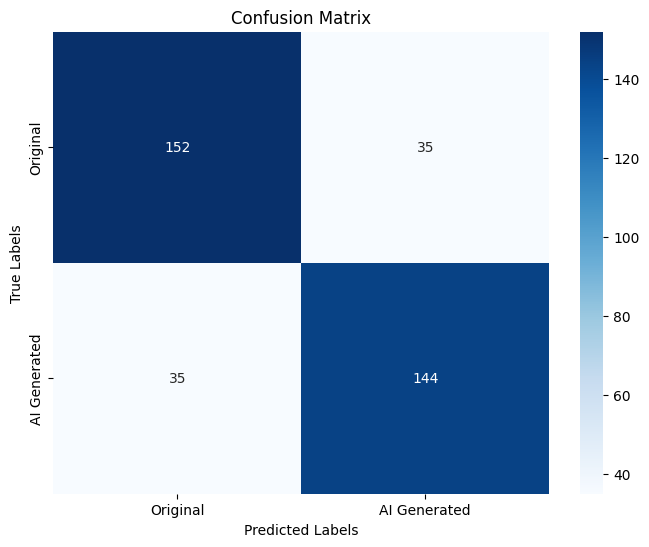

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

predicted_probabilities = model.predict(X_test)

threshold = 0.5
predicted_labels = (predicted_probabilities > threshold).astype(int).flatten()

true_labels = y_test.flatten()

cm = confusion_matrix(true_labels, predicted_labels)

class_names = ['Original', 'AI Generated']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


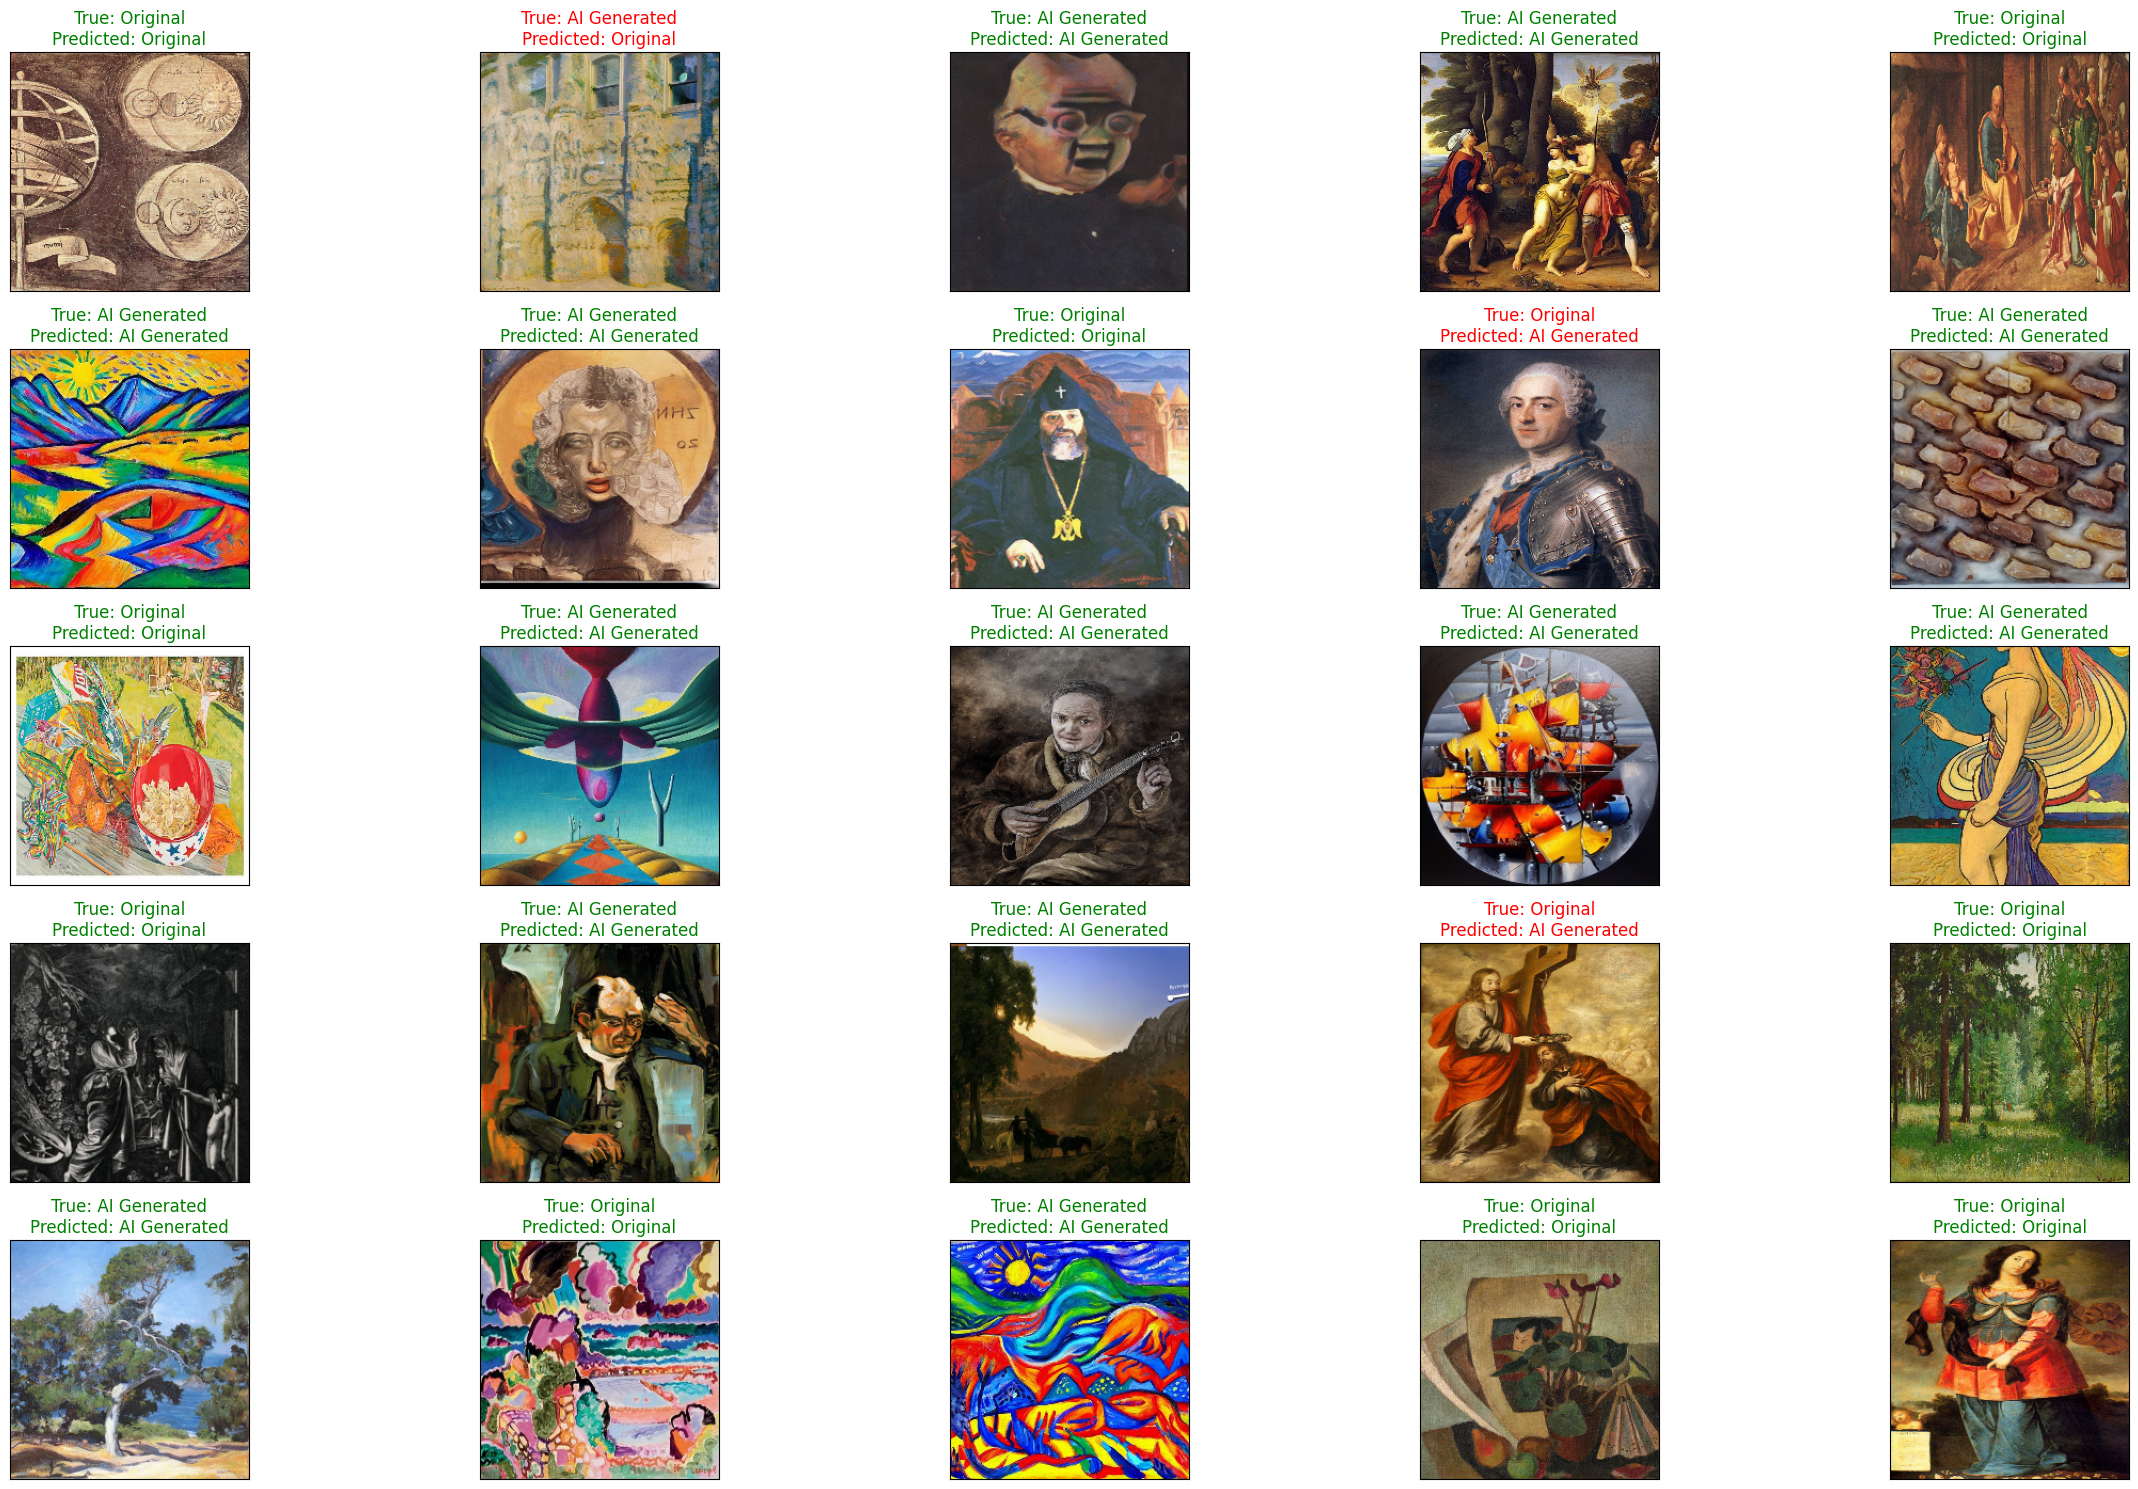

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class labels mapping
class_labels = {0: "Original", 1: "AI Generated"}

# Predict probabilities using the model
predictions = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1) for binary classification
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Select random indices for visualization
random_indices = np.random.choice(len(X_test), size=25, replace=False)

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = X_test[random_indices[i]]
    true_label = y_test[random_indices[i]]
    pred_label = predicted_labels[random_indices[i]]

    # Display the image
    if isinstance(img, str):
        img = plt.imread(img)
    ax.imshow(img)

    # Determine title color based on prediction accuracy
    if true_label == pred_label:
        color = "green"
    else:
        color = "red"

    # Set the title with true and predicted class names
    ax.set_title(f"True: {class_labels[true_label]}\nPredicted: {class_labels[pred_label]}", color=color)

plt.tight_layout()
plt.show()

# Saving Model

In [ ]:
model.save("UltimateOne_Xception.h5")